In [238]:
from bs4 import BeautifulSoup
import re
import sys
import requests
import pandas as pd
from user_agent import generate_user_agent
import matplotlib.pyplot as plt

In [239]:
username = input()

page_link =f'https://myanimelist.net/animelist/{username}?status=2'
headers = {'User-Agent': generate_user_agent(device_type="desktop", os=('mac', 'linux'))}

In [240]:
try:
    page_response = requests.get(page_link, timeout=5, headers=headers)
    if page_response.status_code == 200:
        # parse html
        page_content = BeautifulSoup(page_response.content, 'html.parser')
    else:
        print(page_response.status_code)
        sys.exit()
except:
    print("Something went wrong :(")
    sys.exit()

In [241]:
tables = page_content.find_all('table',{'class':'list-table'})
table_items = re.findall(r'data-items="(\[.*])">', str(tables[0])\
                    .replace('\\&quot;', "'")\
                    .replace('&quot;', '"'))

df = pd.read_json(table_items[0])

finaldf = df.drop(['status', 'created_at', 'updated_at', 'tags', 'anime_id', 'is_rewatching',
                   'num_watched_episodes', 'anime_studios', 'anime_licensors', 'anime_season',
                   'anime_airing_status', 'has_episode_video', 'has_promotion_video', 'has_video',
                   'video_url', 'is_added_to_list', 'start_date_string', 'finish_date_string',
                   'anime_start_date_string', 'anime_end_date_string', 'days_string',
                   'storage_string', 'priority_string', 'notes', 'editable_notes',
                   'title_localized', 'anime_title_eng', 'anime_total_members',
                   'anime_total_scores', 'demographics'], axis=1)

In [242]:
finaldf.rename(columns={
    "score":"User_score",
    "anime_title":"Title",
    "anime_num_episodes":"Episodes",
    "anime_score_val":"Score",
    "genres":"Genres",
    "anime_url":"URL",
    "anime_image_path":"Image",
    "anime_media_type_string":"Type",
    "anime_mpaa_rating_string":"Rating"}, inplace=True)

In [243]:
finaldf['Genres'] = finaldf['Genres'].apply(lambda x: ', '.join(map(lambda x: x['name'], x)))

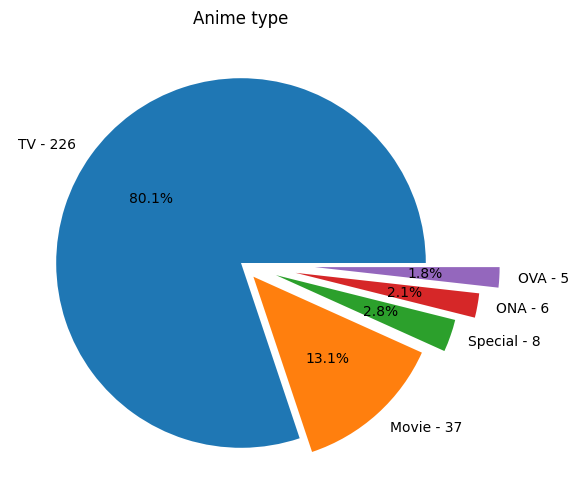

In [244]:
types = finaldf['Type'].value_counts().reset_index()
types.columns = ['Type', 'Count']
types_labels = [k+' - '+str(v) for k, v in zip(types['Type'], types['Count'])]
types.set_index('Type', inplace=True)

ax = types.plot.pie(
    title='Anime type',
    y='Count',
    # shadow=True,
    autopct='%.1f%%',
    explode=[_/10 for _ in range(len(types['Count']))],
    legend=False,
    figsize=(9, 6),
    labels=types_labels)
ax.set_ylabel(None)
plt.show()

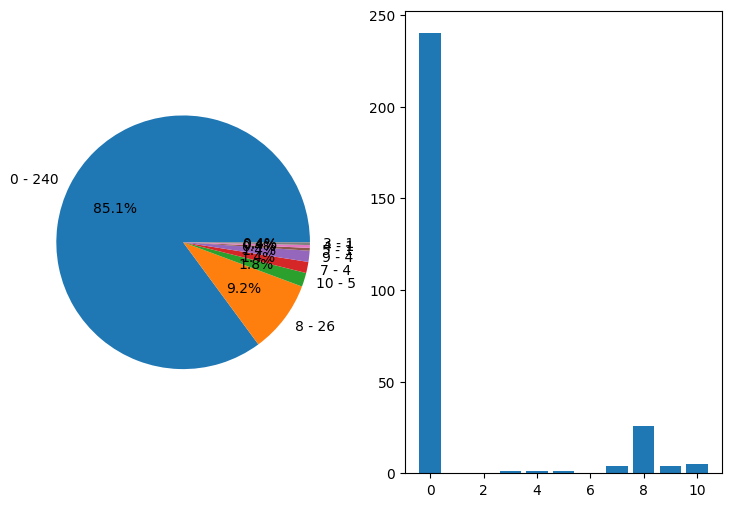

In [254]:
score = finaldf['User_score'].value_counts().reset_index()
score.columns = ['User_score', 'Count']
score.sort_values(by=['User_score'], ascending=False)

score_labels = [str(k)+' - '+str(v) for k, v in zip(score['User_score'], score['Count'])]
# score.set_index('User_score', inplace=True)
# score.plot.pie(y = 'Count',
#                title = 'User score',
#                # shadow = True,
#                # explode = [_/10 for _ in range(len(score['Count']))],
#                legend = False,
#                autopct='%.1f%%',
#                # pctdistance=0.8,
#                figsize = (6, 6),
#                labels = score_labels)
fig, axs = plt.subplots(1, 2, figsize=(9, 6))
axs[0].pie(
    score['Count'],
    autopct='%.1f%%',
    labels = score_labels)
axs[1].bar(
    score['User_score'],
    score['Count'])
plt.show()


In [246]:
genres = pd.DataFrame.from_dict\
        (
    finaldf['Genres']
    .apply(lambda x: pd.value_counts(x.split(", ")))
    .sum(axis = 0)
    .reset_index()
        )
genres.columns=["Genre", "Quantity"]

<Axes: xlabel='Genre'>

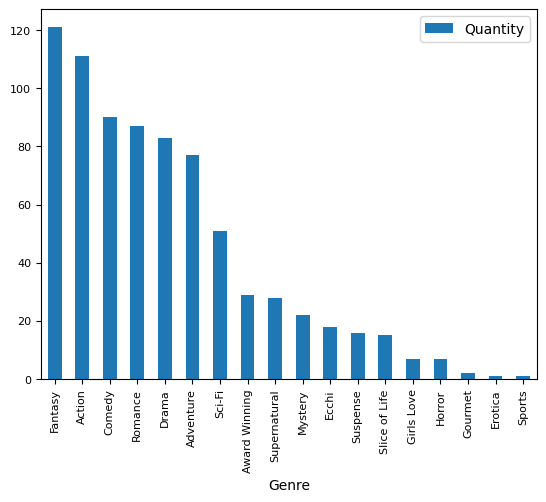

In [247]:
genres = genres.sort_values(by=['Quantity'],  ascending=False)
genres.plot(kind='bar', x="Genre", y="Quantity", fontsize=8)